<a href="https://colab.research.google.com/github/rp1177/CS461-MachineLearning-Principles/blob/main/Riddhi_Patel_sol2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, import some useful packages and set everything up.

In [ ]:
import copy
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import random
import seaborn

from collections import Counter

def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)

set_seed(42)

# Data

Download the MNIST data from the [course Kaggle page](https://www.kaggle.com/competitions/rutgers-cs461-hw2-fall-2023). We will assume that we have the directory `data/mnist/` in our Google Drive account. Let's load the data and stare at it.  

In [ ]:
# Load the Drive helper and mount. You will have to authorize this operation.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
datadir = '/content/drive/My Drive/data/MNIST/'

class MNISTDataset:

  def __init__(self, split):
    assert split in ['train', 'train_small', 'val', 'test']
    self.inputs = np.load('{:s}inputs_{:s}.npy'.format(datadir, split))
    self.labels = None
    if split != 'test':
      self.labels, self.label_count = self.get_labels('{:s}labels_{:s}.npy'.format(datadir, split))
      assert self.labels.shape[0] == self.inputs.shape[0]
    self.split = split

  def get_labels(self, filepath):
    label_matrix = np.load(filepath)  # (num_examples, num_labels)
    labels = np.zeros((len(label_matrix), 1)).astype(int)  # (num_examples, 1)
    label_count = Counter()
    for i in range(len(label_matrix)):
      label= np.nonzero(label_matrix[i])[0][0]
      labels[i] = label
      label_count[label] += 1

    return labels, label_count

  def num_examples(self):
    return self.inputs.shape[0]

  def dim(self):
    return self.inputs.shape[1]

  def generate_batch(self, batch_size):
    inds = list(range(self.num_examples()))
    if self.split == 'train':  # If train, shuffle example indices before generating
      random.shuffle(inds)
    for i in range(0, len(inds), batch_size):
        inds_batch = inds[i: i + batch_size]
        X = self.inputs[inds_batch, :]
        y = self.labels[inds_batch, :] if self.labels is not None else None
        yield X, y

dataset_train = MNISTDataset('train')
dataset_val = MNISTDataset('val')
dataset_test = MNISTDataset('test')

print('Number of examples (train/val/test): {:d}/{:d}/{:d}'.format(dataset_train.num_examples(), dataset_val.num_examples(), dataset_test.num_examples()))
print('Original number of features (image represented as a vector): {:d}'.format(dataset_train.dim()))
print('First training input looks like this...', dataset_train.inputs[0, 160:200])
print('Label: ', dataset_train.labels[0, 0])

Number of examples (train/val/test): 20000/10000/10000
Original number of features (image represented as a vector): 784
First training input looks like this... [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6 95 95 95 95
 95 95 95 95 95 31 39  0  0  0  0  0  0  0  0  0]
Label:  5


Note that we don't have labels for the test portion. We can do a better job of visualizing the inputs.

In [ ]:
def visualize_image(image_raw):
  image = image_raw.reshape(28, 28)  # Reshape a vector into a square
  fig = matplotlib.pyplot.figure()
  ax = fig.add_subplot(1, 1, 1)
  imgplot = ax.imshow(image, cmap=matplotlib.cm.Greys)
  imgplot.set_interpolation("nearest")
  ax.xaxis.set_ticks_position("top")
  ax.yaxis.set_ticks_position("left")
  matplotlib.pyplot.axis("off")
  matplotlib.pyplot.show()

First training input


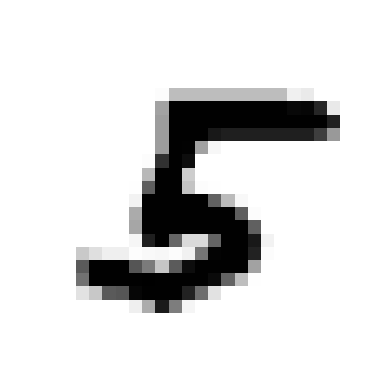

Label:  5


In [ ]:
print('First training input')
visualize_image(dataset_train.inputs[0])
print('Label: ', dataset_train.labels[0, 0])

The dataset is balanced so that we have an equal amount of supervision for each class. This is a luxury: in the wild we will need to deal with datasets with possibly very unbalanced datasets.

In [ ]:
for digit in range(10):
  print('Digit {:1d} has {:3d} training examples'.format(digit, dataset_train.label_count[digit]))

Digit 0 has 2000 training examples
Digit 1 has 2000 training examples
Digit 2 has 2000 training examples
Digit 3 has 2000 training examples
Digit 4 has 2000 training examples
Digit 5 has 2000 training examples
Digit 6 has 2000 training examples
Digit 7 has 2000 training examples
Digit 8 has 2000 training examples
Digit 9 has 2000 training examples


## Feature Normalization

Raw pixel values have high variance and are not mean-centered. To make learning more effective, we'll preprocess the data and normalize each feature (i.e., each pixel) so that each has mean 0 and variance 1 ("$z$-scoring"), similar to what we did in the regression assignment.

In [ ]:
def normalize_features(X, mu=None, sigma=None):
  if mu is None or sigma is None:
    mu = X.mean(0)
    sigma = X.std(0)
    sigma[sigma < 0.0001] = 1  # Avoid division by zero in case of degenerate features.

  # Normalize features and also add a bias feature.
  X_new = np.concatenate([np.ones((X.shape[0], 1)), (X - mu) / sigma], 1)

  return X_new, mu, sigma

First training input after normalization (not including the bias dimension)


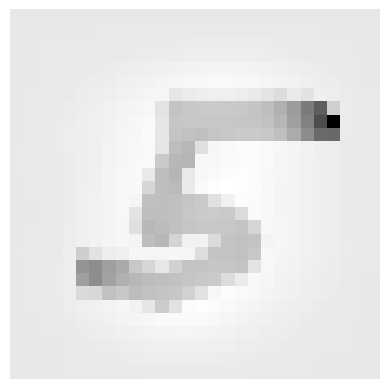

In [ ]:
print('First training input after normalization (not including the bias dimension)')
visualize_image(normalize_features(dataset_train.inputs)[0][0, 1:])

# Softmax

Define a row-wise softmax that turns any rows of label scores (aka. "logits") into probability distributions over labels, with a numerical stability trick.

In [ ]:
def softmax(scores):  # (num_examples, num_labels)
  nonnegs = np.exp(scores - np.amax(scores, axis=1)[:, np.newaxis])  # Mitigate numerical overflow by subtracting max
  return nonnegs / np.sum(nonnegs, axis=1)[:, np.newaxis]

In [ ]:
u = np.array([[-1, 2, 0]])
print(u[0], '=>', softmax(u)[0])

[-1  2  0] => [0.04201007 0.84379473 0.1141952 ]


Also, define a row-wise logsumexp that computes the log of the sum of the elements of each row, with a numerical stability trick.

In [ ]:
def logsumexp(scores):  # (num_examples, num_labels)
  rowwise_max = np.amax(scores, axis=1)[:, np.newaxis]
  return rowwise_max + np.log(np.sum(np.exp(scores - rowwise_max), axis=1)[:, np.newaxis])

In [ ]:
v = np.array([[-1, -2, 3]])
print(logsumexp(v)[0, 0])
print(np.log(np.exp(v).sum()))

print()
w = np.array([[999, 997, 990]])
print(logsumexp(w)[0, 0])
print(np.log(np.exp(w).sum()))  # Without the numerical stability trick, we will encounter an overflow here.

3.0247448901388228
3.0247448901388228

999.1270367041305
inf


<ipython-input-13-d4c2c24538da>:8: RuntimeWarning: overflow encountered in exp
  print(np.log(np.exp(w).sum()))  # Without the numerical stability trick, we will encounter an overflow here.


# Model

Our model is a simple linear classifier that treats each image as a single vector. The feature normalization above introduces a bias dimension, so the model does have a bias parameter. Thus the model parameter is a single matrix $W \in \mathbb{R}^{d \times L}$ where $d$ is the dimension of the input (including the bias dimension) and $L$ is the number of labels (here, 10). The $l$-th column $w_l$ of $W$ computes the score of the given input $x \in \mathbb{R}^d$ for the $l$-th label as $w_l^\top x \in \mathbb{R}$. The model has two key functions:

- `forward`: Given $N$ images in a minibatch, it computes scores/logits for all $L=10$ labels, which you can represent as an $N \times L$ matrix. This is all you need to make inference (you just pick argmax), but if it's additionally given gold labels it will also compute the *sum* of per-example negative log probabilities, plus a regularization term,
$$
- \sum_{i=1}^N \log \frac{\exp(w_{y_i}^\top x_i)}{\sum_{l=1}^L \exp(w_l^\top x_i)} + \lambda \sum_{l=1}^L \sum_{j=2}^d W_{j,l}^2
$$
($\lambda \geq 0$ is a hyperparameter that decides the strength of regularization, note that we don't regularize the bias parameters). This is used for monitoring purposes later. More importantly, it will call the next function to calculate gradients.

- `accumulate_gradients`: Given $N$ images and gold labels, it computes the gradient of the *average* of per-example negative log probabilities, plus the regularization term,
$$
\hat{J}(W) = - \frac{1}{N} \sum_{i=1}^N \log \frac{\exp(w_{y_i}^\top x_i)}{\sum_{l=1}^L \exp(w_l^\top x_i)} + \lambda \sum_{l=1}^L \sum_{j=2}^d W_{j,l}^2
$$
with respect to $W$ evaluated at the *current* value of $W$, then accumulates $\nabla \hat{J}(W) \in \mathbb{R}^{d \times L}$ for gradient-based optimization.

In [ ]:
class LinearClassifier:

  def __init__(self, inputs_train, num_labels, init_range=0.0):
    new_features, self.mu, self.sigma = normalize_features(inputs_train)  # Get means and standard devations
    self.dim = new_features.shape[1]

    # Initialize parameters.
    self.W = np.random.uniform(-init_range, init_range, (self.dim, num_labels))

    # Initialize the gradient.
    self.W_grad = np.zeros((self.dim, num_labels))

  def forward(self, X_raw, y=None, regularization_weight=0.):
    X = normalize_features(X_raw, self.mu, self.sigma)[0] #normalize the input x, to meet mean 0 and variance 1 universally
    scores = np.matmul(X, self.W)  # (batch_size, num_labels) returns a matrix product W param
    loss_sum = None
    if y is not None:  # We're given gold labels, we're training.

      # TODO: Compute the negative log probabilities here using logsumexp. The NumPy function take_along_axis will also be useful. [Problem 5]
      extracted = np.take_along_axis(scores, y, axis=1)
      negative_log_probs = -logsumexp(extracted) + logsumexp(scores) # (batch_size,) original output = "None"

      squared_norm_W = np.linalg.norm(self.W[1:, :], 'fro') ** 2  # Don't regularize bias parameters
      loss_sum = np.sum(negative_log_probs) + regularization_weight * squared_norm_W #the complete forumula for forward function given above
      self.accumulate_gradients(X, y, scores, regularization_weight)

    return loss_sum, scores

  def accumulate_gradients(self, X, y, scores, regularization_weight): ##[Problem 6]
    batch_size, num_labels = scores.shape
    probs = softmax(scores) #probability matrix P

    # TODO: Compute the gradient of the average negative log probability wrt W

    G = np.zeros((batch_size,num_labels)) #set G as an empty array with 0's.
    for i in range(batch_size): #in pset context N = batch size and L = total number of labels
          G[i][y[i]] = 1 #we already sorted out the condition yi = l then G-il = 1 above

    loss_grad = (1 / batch_size) * (np.matmul(X.T, probs) - np.matmul(X.T, G))  # (dim, num_labels)

    # TODO: Compute the gradient of the regularization term (again, remember that bias parameters are not regularized).
    W_mat = self.W.copy() #getting the W matrix we need in order to do the squared_norm_grad 2 * W
    W_mat[0: ,]
    squared_norm_grad = 2 * W_mat  # (dim, num_labels) oring: "None"

    self.W_grad += loss_grad + regularization_weight * squared_norm_grad

  def predict(self, X_raw):
      _, scores = self.forward(X_raw)
      preds = np.argmax(scores, axis=1)[:, np.newaxis]  # (batch_size, 1)
      return preds

  def zero_grad(self):
    self.W_grad.fill(0.)

  def num_parameters(self):
    return self.W.size

## Gradient Check

One useful way to ensure that your gradient computation is absolutely correct is to do what's called the **gradient check**. Recall that *by definition* the derivative of a function $f$ of some scalar variable $x \in \mathbb{R}$ evaluated at $x = a$ is:

$$
f'(a) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{\epsilon}
$$

Thus we can set some small $\epsilon > 0$ and check if this is indeed the case for our gradients. Remember, in our case the function of interest is $\hat{J}(W)$ above, defined on a single batch of labeled examples. We are calculating the gradient of that function with respect to model parameters $W$. Even though this is matrix-valued, a gradient is simply an array of partial derivatives so we can check each derivative individually.

In [ ]:
import unittest

class TestGradient(unittest.TestCase):

  def setUp(self):
    set_seed(42)
    dim = 100
    num_labels = 7
    num_examples = 10
    self.model = LinearClassifier(np.random.randn(num_examples, dim), num_labels, init_range=0.01)
    self.X = np.random.randn(num_examples, dim)
    self.y = np.random.randint(num_labels, size=(num_examples, 1))
    self.epsilon = 1e-4
    self.regularization_weight = 0.01
    self.loss_avg = self.model.forward(self.X, self.y, self.regularization_weight)[0] / num_examples
    self.model.zero_grad()

  def test_gradient_W(self):
    for i in range(self.model.W.shape[0]):
      for j in range(self.model.W.shape[1]):
        self.model.W[i, j] += self.epsilon
        loss_avg_perturbed = self.model.forward(self.X, self.y, self.regularization_weight)[0] / self.X.shape[0]
        partial_derivative_i_j = self.model.W_grad[i, j]
        truth = (loss_avg_perturbed - self.loss_avg) / self.epsilon
        error = abs(partial_derivative_i_j - truth)
        self.assertLess(error, 1e-3)
        self.model.W[i, j] -= self.epsilon
        self.model.zero_grad()

unittest.main(TestGradient(), argv=[''], verbosity=2, exit=False)

test_gradient_W (__main__.TestGradient) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.156s

OK


# Training

We will use stochastic gradient descent (SGD) to optimize the average cross-entropy loss above. Define a simple SGD optimizer class, which updates parameters of the associated model.

In [ ]:
class SGDOptimizer:

  def __init__(self, model, learning_rate):
    self.model = model
    self.lr = learning_rate

  def step(self):
    self.model.W -= self.lr * self.model.W_grad

  def zero_grad(self):
    self.model.zero_grad()

  def modify_lr(self, learning_rate):
    self.lr = learning_rate

In [ ]:
def evaluate_accuracy(model, dataset_eval, batch_size_eval=64):
  num_correct = 0
  for X, y in dataset_eval.generate_batch(batch_size_eval):
    num_correct += np.sum(model.predict(X) == y)
  return num_correct / dataset_eval.num_examples() * 100.

In [ ]:
def train(dataset_train, dataset_val, learning_rate=0.1, init_range=0., batch_size=16, regularization_weight=0., max_num_epochs=10, seed=42, loss_improvement=0.01, decay=2., tolerance=5, verbose=False):
  set_seed(seed)
  model = LinearClassifier(dataset_train.inputs, 10, init_range=init_range)
  optimizer = SGDOptimizer(model, learning_rate)

  best_acc_val = float('-inf')
  best_W = None
  num_continuous_fails = 0
  loss_avg_before = None

  if verbose:
    print('Num parameters {:d}'.format(model.num_parameters()))
    print('Batch size {:d}, learning rate {:.5f}, regularization_weight {:.5f}'.format(batch_size, learning_rate, regularization_weight))

  for epoch in range(max_num_epochs):
    loss_total = 0.
    num_correct = 0

    for X, y in dataset_train.generate_batch(batch_size):  # Shuffled in each epoch
      loss_sum, scores = model.forward(X, y, regularization_weight)
      loss_total += loss_sum
      preds = np.argmax(scores, axis=1)[:, np.newaxis]
      num_correct += np.sum(preds == y)

      optimizer.step()
      optimizer.zero_grad()

    loss_avg = loss_total / dataset_train.num_examples()
    acc_train = num_correct / dataset_train.num_examples() * 100.
    acc_val = evaluate_accuracy(model, dataset_val)

    if acc_val > best_acc_val:
      num_continuous_fails = 0
      best_acc_val = acc_val
      best_W = copy.deepcopy(model.W)
    else:
      num_continuous_fails += 1
      if num_continuous_fails > tolerance:
        if verbose:
            print('Early stopping')
        break

    if loss_avg_before is not None:
      if loss_avg_before - loss_avg < loss_improvement:  # Training loss has not improved sufficiently, decay the learning rate
        optimizer.modify_lr(optimizer.lr / decay)
        if verbose and decay != 1.0:
          print('Decaying learning rate to {:.5f}'.format(optimizer.lr))
    loss_avg_before = loss_avg

    if verbose:
      print('End of epoch {:3d}:\t loss avg {:10.4f}\t acc train {:10.2f}\t acc val {:10.2f}'.format(
          epoch + 1, loss_avg, acc_train, acc_val))

  model.W = best_W
  if verbose:
    print('Best acc val: {:10.2f}'.format(best_acc_val))

  return model, best_acc_val, loss_avg, acc_train

In [ ]:
model, acc_val, loss_avg, acc_train = train(dataset_train, dataset_val, learning_rate=5., batch_size=24, decay=2, verbose=True)

Num parameters 7850
Batch size 24, learning rate 5.00000, regularization_weight 0.00000
End of epoch   1:	 loss avg    17.2524	 acc train      84.07	 acc val      85.35
End of epoch   2:	 loss avg    16.6815	 acc train      87.42	 acc val      85.83
End of epoch   3:	 loss avg    15.8227	 acc train      88.53	 acc val      86.73
End of epoch   4:	 loss avg    14.2583	 acc train      88.86	 acc val      88.78
Decaying learning rate to 2.50000
End of epoch   5:	 loss avg    14.6887	 acc train      89.48	 acc val      87.59
End of epoch   6:	 loss avg     9.1016	 acc train      91.42	 acc val      88.67
End of epoch   7:	 loss avg     7.1605	 acc train      91.85	 acc val      88.50
End of epoch   8:	 loss avg     6.2920	 acc train      91.70	 acc val      87.49
End of epoch   9:	 loss avg     6.0824	 acc train      91.39	 acc val      88.13
Early stopping
Best acc val:      88.78


Observation: We are training using Stochastic gradient descent learning algorithm and our model is a linear classification. When training we do not tune our regularization parameter "regularization_weight" but only the learning rate.

We decay the learning rate when we see the validation accuracy not change significantly as well as possibly to prevent overfitting of the data

# Hyperparameter Tuning

Experiments usually involve heavy hyperparameter tuning. This means you try a few different values of key hyperparameters to find one that works best (on validation data). For stochastic gradient descent, two important hyperparameters are the *batch size* and the *learning rate*. These two interact, so you have to search over their joint space. Typically you change them on a logarithmic scale (e.g., 0.0001, 0.001, 0.01, 0.1 for learning rates, 16, 32, 64, 128, 256 for batch sizes).

However, to focus on the effect of regularization, we will fix the batch size and learning rate to be some reasonable values and only vary the regularization weight.

In [ ]:
model_best = None
best_acc_val = float('-inf')
for batch_size in [16]:
  for learning_rate in [0.1]:
    for regularization_weight in [0, 0.0001, 0.001, 0.01, 1.0, 10.0]:
      model, acc_val, loss_avg, acc_train = train(dataset_train, dataset_val, learning_rate=learning_rate, batch_size=batch_size, regularization_weight=regularization_weight, max_num_epochs=60)
      print('Lambda {:10.4f}\t loss {:10.4f}\t acc train {:2.2f}\t acc val {:2.2f}'.format(regularization_weight, loss_avg, acc_train, acc_val))
      if acc_val > best_acc_val:
        best_acc_val = acc_val
        model_best = copy.deepcopy(model)

Lambda     0.0000	 loss     0.1609	 acc train 95.70	 acc val 90.78
Lambda     0.0001	 loss     0.1639	 acc train 95.63	 acc val 90.90
Lambda     0.0010	 loss     0.2043	 acc train 94.56	 acc val 91.53
Lambda     0.0100	 loss     0.2966	 acc train 92.26	 acc val 91.35
Lambda     1.0000	 loss     1.0889	 acc train 83.14	 acc val 82.97
Lambda    10.0000	 loss     1.9727	 acc train 75.98	 acc val 75.51


## Question

What is the impact of regularization on training loss/accuracy and validation accuracy?


###Answer:

The impact of regularization on training loss/accuracy and validation accuracy is that the larger the "lambda" or "regularization weight", the more severe the penalty becomes where it acts as  a larger prevention to use overly complex models that can overfit the dataset.

We see that regularization on training loss/accuracy, a lambda with 0 has no regularization involved, and our loss and accuracy is at its peak where we have the smallest loss and our model closely fits the training data. However, the more we tune and increase the lambda, our loss and training results slowly increase. This shows that we are straying away from overfitting the data by relying on complex models. The more we stray away from complex models (by increasing lambda), the more our accuracy and loss plummets.

Additionally, when it comes to validation accuracy, we also witness similar results where when lambda equals 0 (no regularization present) our validation is high but not too high (90.78). However, the moment when we implment lambda, we reduce complex models from occurring and see that our validation accuracy increases. This means at some certain point based on lambda's ranging from 0.0001-0.0100 our accuracy increases. This means we are able to generalize our data better in the long run. In other words we limit the amount of complex models perfectly. However, if we increase our lambda to 10, that makes the penalty even harsher that we would not almost have complex models at all, our generalization and accuracy for validation would become poor as a result.

In essence, regularization helps prevent overfitting by penalizing overly complex models, leading to better generalizability and validation accuracy. However, excessive regularization can cause problems for model complexity and negatively impact the validation accuracy.

# Qualitative Analysis

## Weight Visualization

Since the model parameters are $w_l \in \mathbb{R}^d$ for $l = 1 \ldots 10$ where the $(i+1)$th dimension corresponds to how much the $i$-th pixel value (shifted due to the bias dimension) implies the $l$-th label (i.e., digit $l-1$), we can directly visualize the parameters.

In [ ]:
def visualize_model(model):
  fig = plt.figure(figsize=(20,10))
  for label in range(10):
    plt.subplot(2, 5, label + 1)
    plt.imshow(model.W[1:, label].reshape(28, 28))
    plt.title('Label {:d}'.format(label))
    plt.colorbar()
  plt.show()

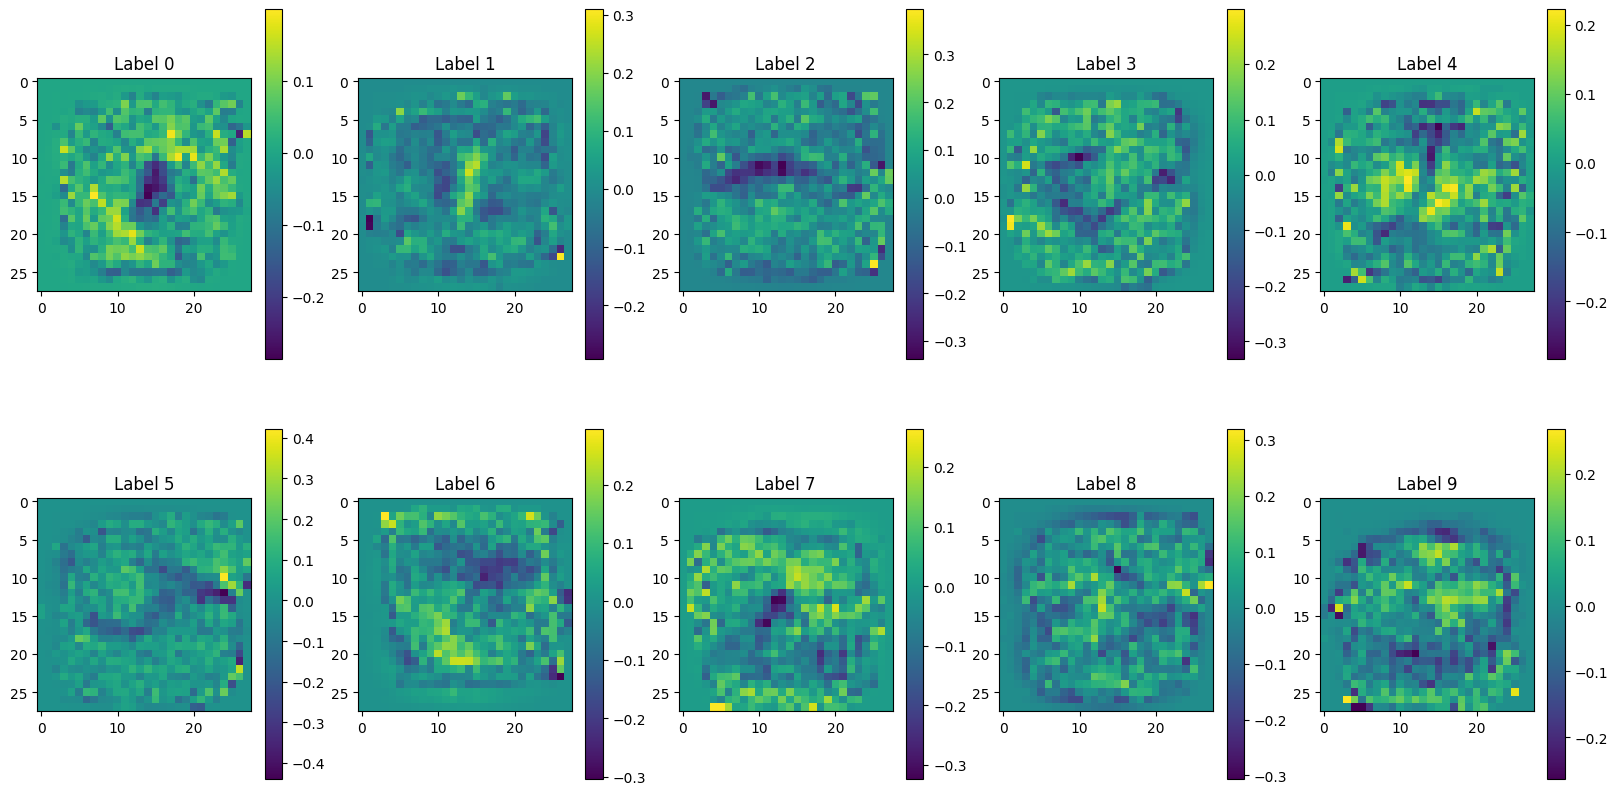

In [ ]:
visualize_model(model_best)

### Question

What do you observe about the visualized weights for each class label?

###Answer:

I believe its hard to make observations or conclusions of the visualized weights for each label graphically. It would be more efficient to observe direct numbers in a circumstance such as this to understand or observe patterns/changes per label, especially when under larger training data.



## Confusion Matrix


Because we only have 10 labels we can easily visualize the prediction behavior of the model through a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

In [ ]:
def build_confusion_matrix(model, dataset_val, batch_size_eval=64):
  confusion_matrix = [[0 for _ in range(10)] for _ in range(10)]
  for X, y in dataset_val.generate_batch(batch_size_eval):
    preds = model.predict(X)
    for i in range(X.shape[0]):
      confusion_matrix[y[i, 0]][preds[i][0]] += 1

  for label1 in range(10):
    num_label1_total = sum(confusion_matrix[label1])
    for label2 in range(10):
      confusion_matrix[label1][label2] /= num_label1_total / 100

  return confusion_matrix

<Axes: >

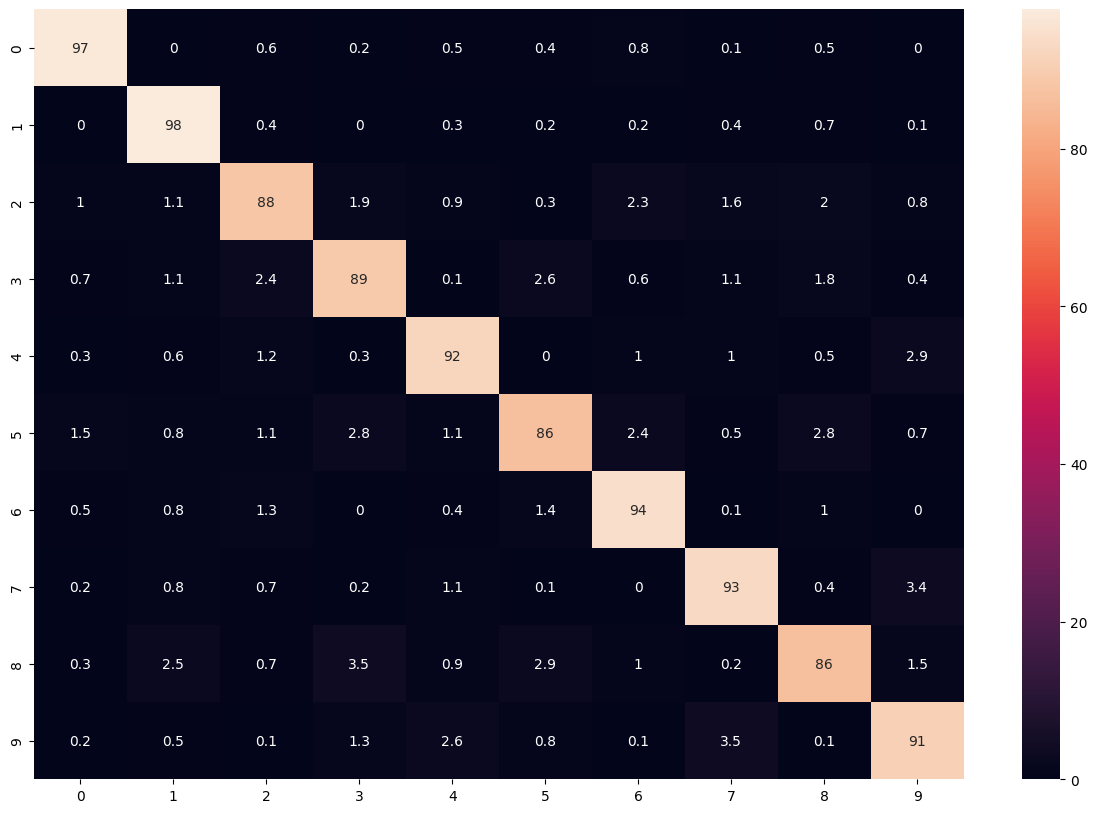

In [ ]:
df = pandas.DataFrame(build_confusion_matrix(model_best, dataset_val),
                      index=[str(digit) for digit in range(10)], columns=[str(digit) for digit in range(10)])
plt.figure(figsize = (15,10))
seaborn.heatmap(df, annot=True)

### Question

What do you observe in the confusion matrix?

###Answer:

What we observed in the confusion matrix is that we are comparing our actual class labels (represented by the rows of the matrix) versus our model's predicted class labels (represented by the columns of the matrix) in terms of percentages. The diagonal represents if we correctly classified our model predictions of the class labels with the actual label (so prediction class = actual class accuracy). However, the blacked out elements represent labels that were incorrectly classified.

We see that the diagonal values are high in range, with our lowest value being only 86% for labels 5 and 8. The rest are above 86%. Meanwhile our non-diagonal values are low within the range of 0-1. However, there are some small spikes near 2-3 but nothing greater than that. This gives us the indication that our model is performing well.

Additionally, I observed that every row from correct classification predictions and errors equals to 100.

# Small Data Regime

To study the effect of the amount of supervision, we will train the model on a small subset of the training dataset with 30 examples total (3 examples per digit).

In [ ]:
dataset_train_small = MNISTDataset('train_small')

print(dataset_train_small.num_examples())
for digit in range(10):
  print('Digit {:1d} now has only {:1d} training examples'.format(digit, dataset_train_small.label_count[digit]))

30
Digit 0 now has only 3 training examples
Digit 1 now has only 3 training examples
Digit 2 now has only 3 training examples
Digit 3 now has only 3 training examples
Digit 4 now has only 3 training examples
Digit 5 now has only 3 training examples
Digit 6 now has only 3 training examples
Digit 7 now has only 3 training examples
Digit 8 now has only 3 training examples
Digit 9 now has only 3 training examples


Let's again do a model selection over the choice of $\lambda$ (regularization strength), with batch size/learning rate fixed to some reasonable values.

In [ ]:
model_best_small = None
best_acc_val_small = float('-inf')
for batch_size in [8]:
  for learning_rate in [0.1]:
    for regularization_weight in [0, 0.0001, 0.001, 0.01, 1.0, 10.0]:
      model, acc_val, loss_avg, acc_train = train(dataset_train_small, dataset_val, learning_rate=learning_rate, batch_size=batch_size, regularization_weight=regularization_weight, max_num_epochs=60)
      print('Lambda {:10.4f}\t loss {:10.4f}\t acc train {:2.2f}\t acc val {:2.2f}'.format(regularization_weight, loss_avg, acc_train, acc_val))
      if acc_val > best_acc_val_small:
        best_acc_val_small = acc_val
        model_best_small = copy.deepcopy(model)

Lambda     0.0000	 loss     0.0212	 acc train 100.00	 acc val 56.37
Lambda     0.0001	 loss     0.0213	 acc train 100.00	 acc val 56.36
Lambda     0.0010	 loss     0.0219	 acc train 100.00	 acc val 56.37
Lambda     0.0100	 loss     0.0273	 acc train 100.00	 acc val 56.35
Lambda     1.0000	 loss     0.4643	 acc train 100.00	 acc val 57.82
Lambda    10.0000	 loss     1.6374	 acc train 100.00	 acc val 56.02


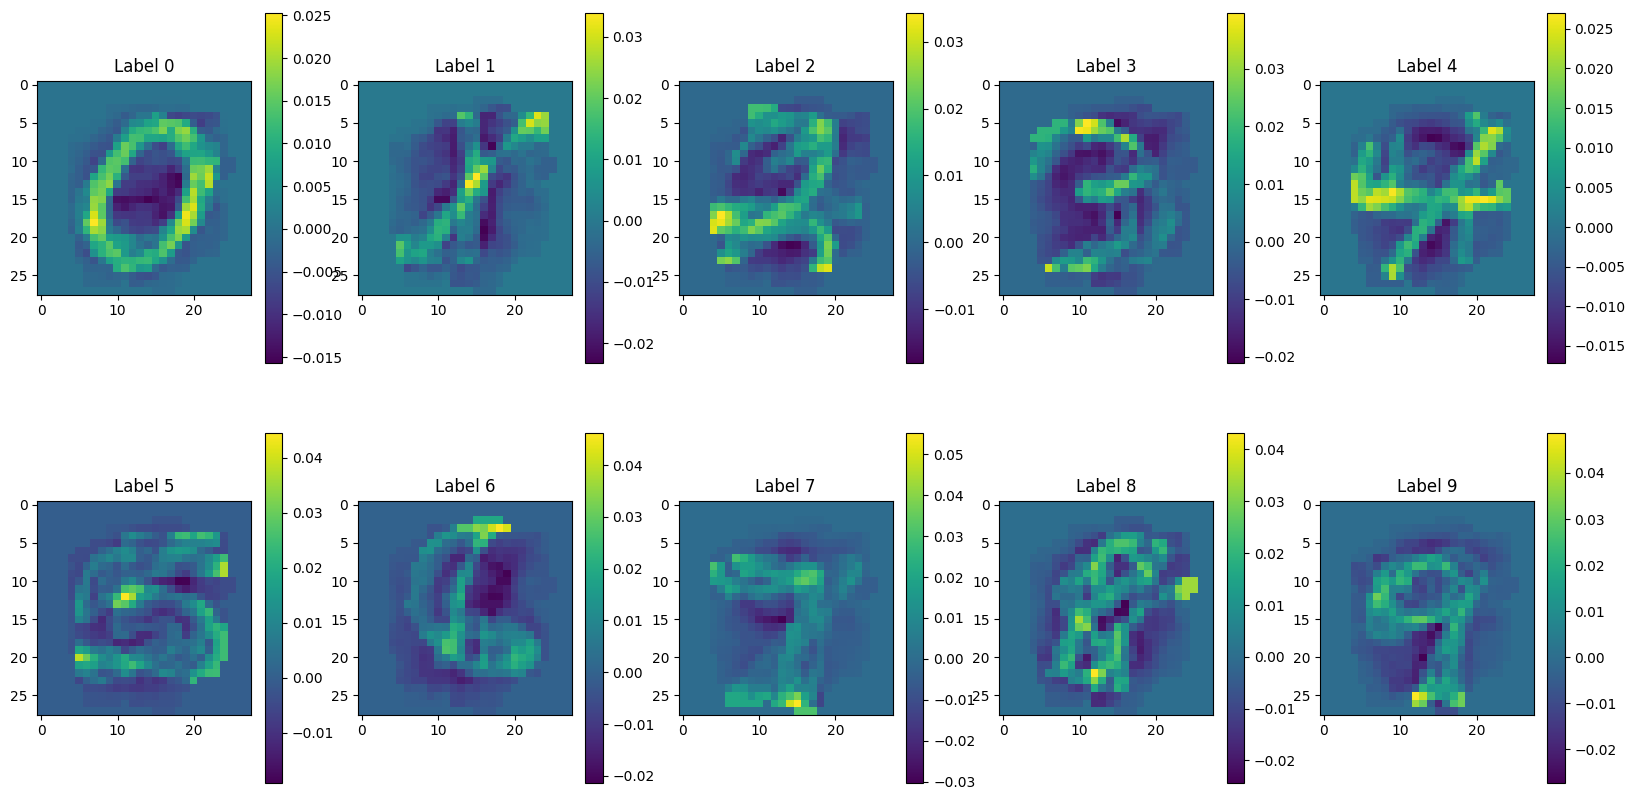

In [ ]:
visualize_model(model_best_small)

<Axes: >

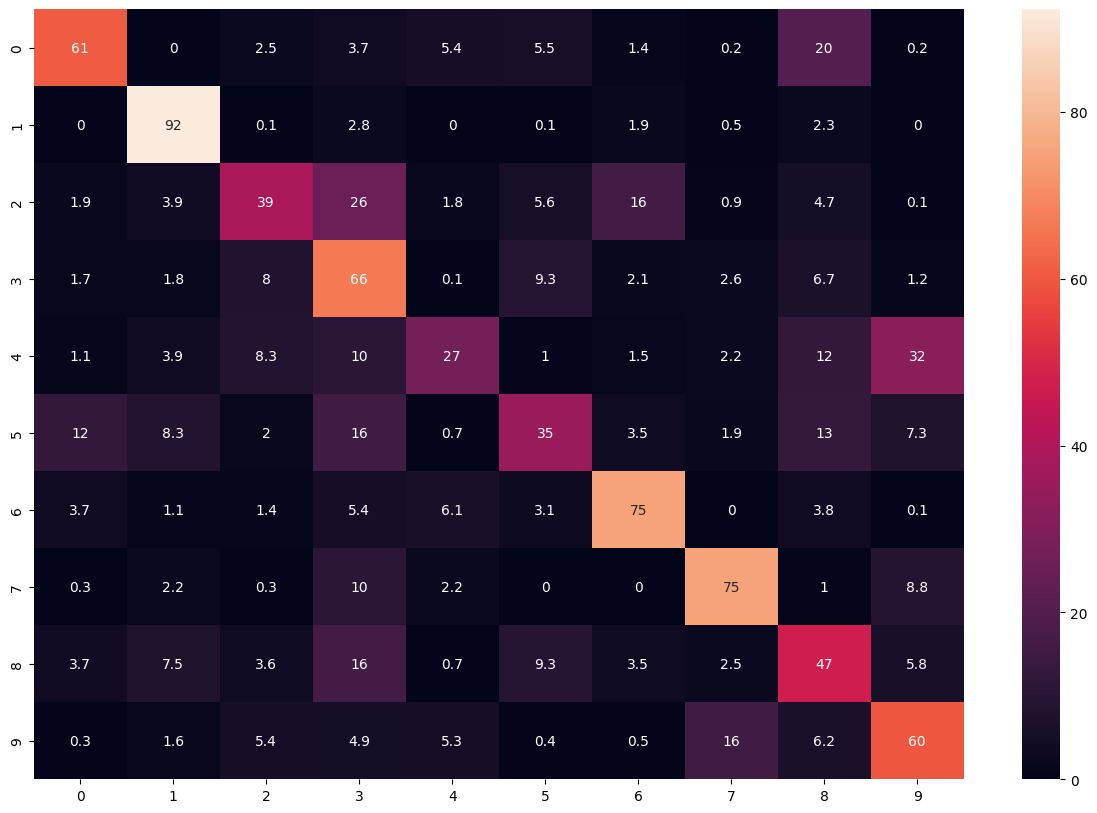

In [ ]:
df = pandas.DataFrame(build_confusion_matrix(model_best_small, dataset_val),
                      index=[str(digit) for digit in range(10)], columns=[str(digit) for digit in range(10)])
plt.figure(figsize = (15,10))
seaborn.heatmap(df, annot=True)

## Question

What do you observe about the *weight visualization* and *confusion matrix* **compared to the large training data** setting?


###Answer:

When I observed the small train data setting, numerical values were intriguing. I am aware that we are training for each label 3 training examples. For all lambda values our training accuracy was 100% and the loss was very minimal within 0-1 range. However, our validation accuracy was relatively low within 56-57% accuracy for all lambda ranges which gives me the sign it isn't a good model to predict with new data. It is further evident with the weight visualization compared to the larger training data version, we are better able to visualize our labels graphically in this circumstance, which initially we may think that this is a good thing. But if we observe the confusion matrix we see that our diagonal shows poor accuracy in choosing the correct classification, and our non-diagonal values are shown in different shades of colors indicating that our predicting class errors are significantly high and not within a consistent range within 0-1. This gives us an indication on smaller training data our model will not perform well.

Our weight visualization is more clear to see with smaller training data compared to larger training data, meaning it has shifted less. However, it hides more mistakes that we may not be able to notice with the smaller training data. The confusion matrix helps us illustrate those errors we may miss. The larger training data set under the confusion matrix illustrated for us that our model is performing well, however, with smaller training data it fails to perform well.

We can then make the conclusion, that under any circumstance, it is good in practice to have a larger training data to help train the model more accurately in order to have better accuracy/generalization when encountering new data. If we have a smaller training data, our training accuracy would be high but we would fail to account for accuracy when it comes to newer data. Meanwhile, if we have more training data to account for, our training accuracy would be mildly consistent but we would have improved validation accuracy.

# Kaggle Submission

To make the assignment more engaging we have a [Kaggle competition](https://www.kaggle.com/t/9f1ee0d997ac4d528f26a3ce8cd94e4d)! We will make test predictions with the best model we can train on the full training dataset (best in validation accuracy). Don't use more training data (in particular, don't retrain on train+val), but you can go back to the hyperparameter tuning and search other values of

- Batch size
- Learning rate
- Max number of epochs
- Learning rate decay

and others. It's fine to "guess" at this or that value, but it's usually best to be systematic about it and sweep all configurations because we don't know which hyperparameters interact with which (e.g., learning rate interacts strongly with batch size). If you feel ambitious you might even try [different gradient-based optimization methods](https://ruder.io/optimizing-gradient-descent/) like Adagrad or Adam.


In [ ]:
def create_kaggle_submission(model, dataset_test, netid, batch_size_eval=64):
  preds = []
  for X, _ in dataset_test.generate_batch(batch_size_eval):  # Not shuffled
    preds.extend(model.predict(X)[:, 0].tolist())

  with open('/content/drive/My Drive/cs461hw2_{:s}.csv'.format(netid), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'category'])  # Header
    for i, pred in enumerate(preds):
        writer.writerow([i, pred])

In [ ]:
# Use your best model (assumed model_best) with your NetID here.
create_kaggle_submission(model_best, dataset_test, 'rnp72')

This creates a file in your Google Drive `cs461hw2_mynetid.csv`. You can upload it to Kaggle and check how you're doing compared to others on the public leaderboard (50% of the test data). The final evaluation is shown on the private leaderboard (the other 50% of the test data), which is not revealed until after the competition is over.

## Question

Report the result of your **best model**
- Training accuracy: **91.85**
- Validation accuracy: **88.78**
- Test accuracy on public leaderboard (from Kaggle submission): **0.91340**